⚠️ No file found for HCHO_TROP with tag rfuh
⚠️ No file found for NO2_TROP with tag rnvh
⚠️ No file found for O3 with tag rout
⚠️ No file found for SO2 with tag rsus
⚠️ No file found for H2O with tag rwvt


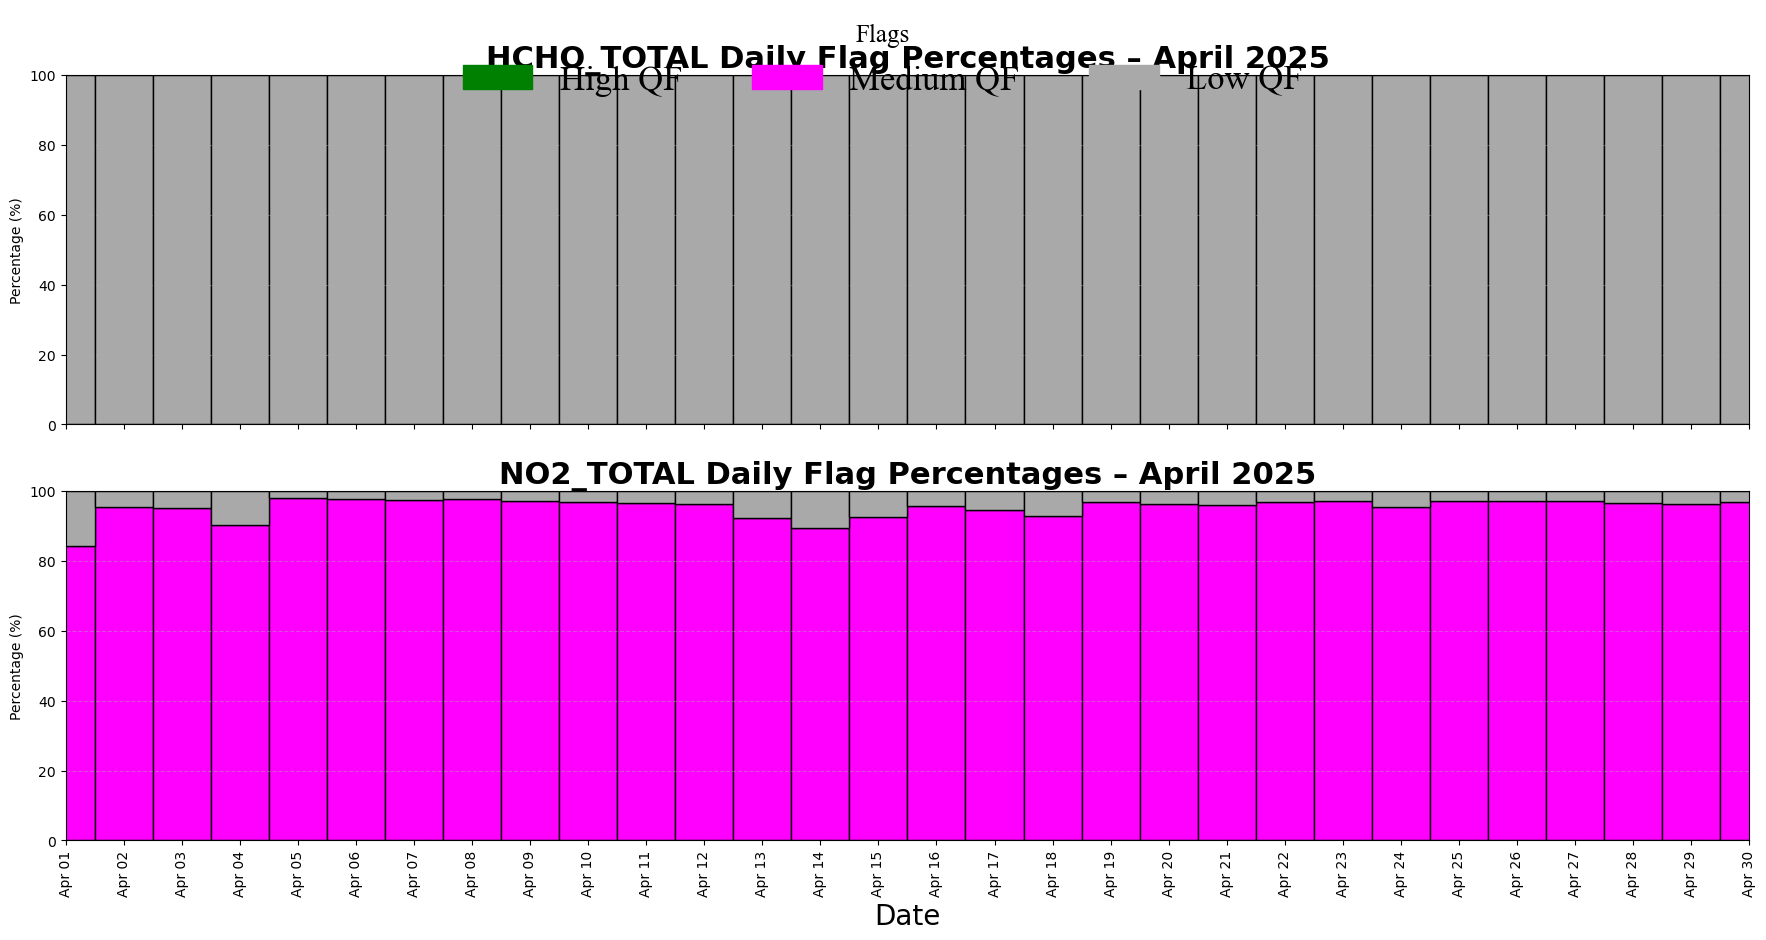

✅ Saved styled figure: Data/Processed/ALLGAS_April2025_Flags_BigFont.png


In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Setup paths ---
data_dir = r'Data'
output_dir = os.path.join(data_dir, 'Processed')
os.makedirs(output_dir, exist_ok=True)

# --- Gas configuration ---
gas_configs = {
    'HCHO_TROP':  {'file_tag': 'rfuh', 'flag_col': 41},
    'HCHO_TOTAL': {'file_tag': 'rfus', 'flag_col': 35},
    'NO2_TROP':   {'file_tag': 'rnvh', 'flag_col': 52},
    'NO2_TOTAL':  {'file_tag': 'rnvs', 'flag_col': 32},
    'O3':         {'file_tag': 'rout', 'flag_col': 35},
    'SO2':        {'file_tag': 'rsus', 'flag_col': 32},
    'H2O':        {'file_tag': 'rwvt', 'flag_col': 32},
}

# --- Helper: Read Pandora txt file ---
def read_pandora_file(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            lines = file.readlines()
    except UnicodeDecodeError:
        with open(filename, 'r', encoding='ISO-8859-1') as file:
            lines = file.readlines()

    break_indices = [i for i, line in enumerate(lines) if line.startswith('---')]
    column_dict = {}
    for i, line in enumerate(lines[break_indices[0]+1:break_indices[1]]):
        if line.startswith('Column'):
            _, value = line.split(':', 1)
            column_dict[i] = value.strip()

    data_lines = [line.strip().split() for line in lines[break_indices[1]+1:] if line.strip()]
    df = pd.DataFrame(data_lines)
    return df, column_dict

# --- Process each file ---
def process_file(filepath, gas_name, config):
    df, col_dict = read_pandora_file(filepath)
    filename = os.path.basename(filepath)

    time_col = 0
    flag_col = config['flag_col']

    try:
        df[time_col] = pd.to_datetime(df[time_col], format='ISO8601', errors='coerce')
        df[flag_col] = pd.to_numeric(df[flag_col], errors='coerce')
        df = df[df[flag_col].isin([10, 11, 12])]
        df = df[[time_col, flag_col]]
        df.columns = ['time', 'Flag']

        if df['time'].isna().all():
            print(f"⚠️ All times invalid in {filename}")
            return None

        return df
    except Exception as e:
        print(f"⚠️ Failed to parse {filename}: {e}")
        return None

# --- Plot April 2025 for all gases ---
def plot_all_gases_april_2025(data_dict):
    gases = list(data_dict.keys())
    fig, axes = plt.subplots(nrows=len(gases), figsize=(18, 5 * len(gases)), sharex=True)

    # Set global font sizes
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': 'Times New Roman',
        'font.size': 18,
        'axes.labelsize': 20,
        'axes.titlesize': 22,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 30
        
    })

    flag_colors = {10.0: 'green', 11.0: 'magenta', 12.0: 'darkgray'}
    legend_labels = {'10.0': 'High QF', '11.0': 'Medium QF', '12.0': 'Low QF'}
    full_dates = pd.date_range('2025-04-01', '2025-04-30').date

    for i, gas in enumerate(gases):
        ax = axes[i] if len(gases) > 1 else axes
        df = data_dict[gas]
        if df is None or df.empty:
            ax.set_title(f"{gas} – No Data for April 2025", fontsize=20, weight='bold')
            ax.axis('off')
            continue

        df_april = df[(df['time'].dt.year == 2025) & (df['time'].dt.month == 4)].copy()
        if df_april.empty:
            ax.set_title(f"{gas} – No Data for April 2025", fontsize=20, weight='bold')
            ax.axis('off')
            continue

        df_april['Date'] = df_april['time'].dt.date
        grouped = df_april.groupby(['Date', 'Flag']).size().unstack('Flag').fillna(0)
        grouped = grouped.reindex(full_dates, fill_value=0)

        percent = grouped.div(grouped.sum(axis=1), axis=0).fillna(0) * 100
        percent = percent.apply(pd.to_numeric, errors='coerce').fillna(0)

        percent.plot(kind='bar', stacked=True,
                     color=[flag_colors.get(f, 'black') for f in percent.columns],
                     ax=ax, edgecolor='k', width=1)

        ax.set_title(f"{gas} Daily Flag Percentages – April 2025", fontsize=22, weight='bold')
        ax.set_ylabel("Percentage (%)")
        ax.set_ylim(0, 100)
        ax.tick_params(axis='x', labelsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        ax.set_xlim([0, len(full_dates)-1])
        ax.set_xticks(range(len(full_dates)))
        ax.set_xticklabels([d.strftime('%b %d') for d in full_dates], rotation=90)

        if ax.get_legend():
            ax.get_legend().remove()

    # Shared legend, closer to subplots
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in flag_colors.values()]
    labels = list(legend_labels.values())
    fig.legend(handles, labels, title="Flags",
               loc="upper center", bbox_to_anchor=(0.5, 0.965),
               ncol=3, fontsize=25, title_fontsize=18, frameon=False)

    axes[-1].set_xlabel("Date", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # Shift space for legend
    save_path = os.path.join(output_dir, "ALLGAS_April2025_Flags_BigFont.png")
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"✅ Saved styled figure: {save_path}")

# --- MAIN ---
processed_data = {}
for gas_name, config in gas_configs.items():
    tag = config['file_tag']
    matching_files = [f for f in os.listdir(data_dir) if tag in f and f.endswith('.txt')]
    if not matching_files:
        print(f"⚠️ No file found for {gas_name} with tag {tag}")
        continue

    filepath = os.path.join(data_dir, matching_files[0])
    df = process_file(filepath, gas_name, config)
    if df is not None:
        processed_data[gas_name] = df

plot_all_gases_april_2025(processed_data)
